# 🛍️ Olist E-commerce Analysis  
### Week 2 Mini Project — Customer Segmentation Exploration  
**Author:** Zain  
**Tools:** Python (Pandas, Matplotlib), Google Colab  


## 📌 Project Overview

This mini-project is part of my 12-week Data Analyst learning journey.  
The goal of Week 2 is to practice **data cleaning**, **transformation**, and **customer segmentation** using the Olist e-commerce dataset.

The project covers:

- Data cleaning (missing values, duplicates, data types)  
- Feature engineering (delivery time, customer spend, AOV)  
- Merging multiple tables  
- Exploratory data analysis  
- Customer segmentation using quantiles  
- Visualizing segment distribution  
- Business insights and revenue concentration analysis  

This notebook is structured so that anyone can follow the full workflow from raw data → insights.


## 1. Importing Libraries

In [ ]:
# all the imports
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import display

**Unzipping the folder**

In [ ]:

with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall()


## 2. Loading Olist Datasets

In [ ]:
customers = pd.read_csv('archive/olist_customers_dataset.csv')
orders = pd.read_csv('archive/olist_orders_dataset.csv')
order_item = pd.read_csv('archive/olist_order_items_dataset.csv')
products = pd.read_csv('archive/olist_products_dataset.csv')

location = pd.read_csv('archive/olist_geolocation_dataset.csv')
order_payments = pd.read_csv('archive/olist_order_payments_dataset.csv')
reviews = pd.read_csv('archive/olist_order_reviews_dataset.csv')
sellers = pd.read_csv('archive/olist_sellers_dataset.csv')
product_category = pd.read_csv('archive/product_category_name_translation.csv')


## 3. Data Cleaning & Preprocessing

In [ ]:
# converting columns into datetime
date_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in date_cols:
  orders[col] = pd.to_datetime(orders[col], errors='coerce')

**3.1 Check for Duplicates**

In [ ]:

orders.duplicated().sum()

np.int64(0)

**3.2 Handling Missing Values**

In [ ]:
orders['delivery_missing'] = orders['order_delivered_customer_date'].isnull()
orders['shipping_missing'] = orders['order_delivered_carrier_date'].isnull()


**3.3 Creating Delivery Time Feature**

In [ ]:
orders['delivery_time_days'] = (
    orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']
).dt.days


**3.4 Delivery Time Statistical Summary**

In [ ]:
orders['delivery_time_days'].describe()


,delivery_time_days
count,96476.000000
mean,12.094086
std,9.551746
min,0.000000
25%,6.000000
50%,10.000000
75%,15.000000
max,209.000000


**3.5 Delivery Time Distribution Visualization**

To better understand how long orders take to reach customers, we visualize the distribution of delivery times (in days). This helps identify patterns, typical wait times, and potential delivery issues.


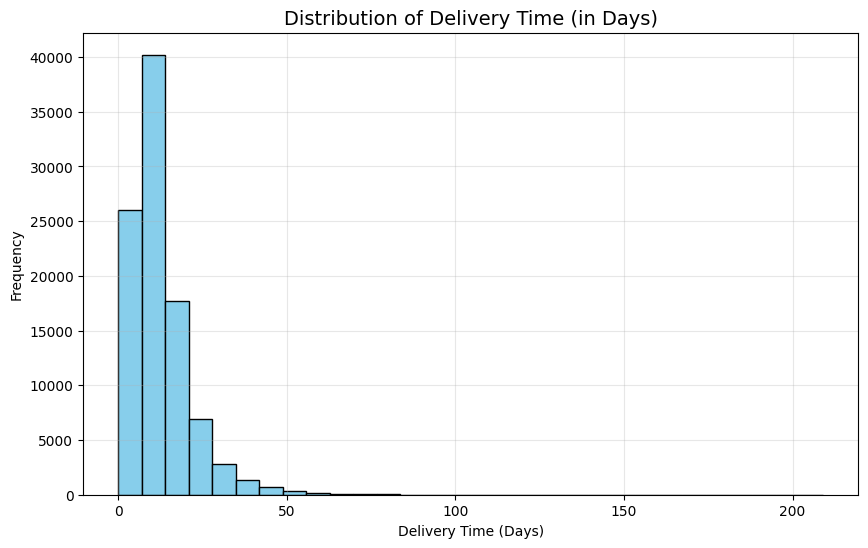

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(orders['delivery_time_days'], bins=30, color='skyblue', edgecolor='black')

plt.title('Distribution of Delivery Time (in Days)', fontsize=14)
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.show()


### Key Observations

- Most orders are delivered between **6–15 days**, which matches the 25th–75th percentile range from the statistical summary.
- The **average delivery time is ~12 days**.
- The distribution is slightly **right-skewed**, meaning a small number of orders take longer than usual.
- Extreme outliers exist (delivery times above 100 days), which likely represent delayed shipments or data quality issues.


**3.6 Detecting Outliers in Delivery Time (IQR Method)**

Outliers in delivery duration can indicate operational issues, delays, or incorrect data entries.  
We use the **Interquartile Range (IQR)** method to identify unusually long or short delivery times.


In [ ]:
# Calculate IQR
Q1 = orders['delivery_time_days'].quantile(0.25)
Q3 = orders['delivery_time_days'].quantile(0.75)
IQR = Q3 - Q1

# Outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = orders[
    (orders['delivery_time_days'] < lower_bound) |
    (orders['delivery_time_days'] > upper_bound)
]

# Show first 5 outlier rows
outliers[['order_purchase_timestamp',
          'order_delivered_customer_date',
          'delivery_time_days']].head()


,order_purchase_timestamp,order_delivered_customer_date,delivery_time_days
29,2018-02-25 13:50:30,2018-03-27 23:29:14,30.0
35,2018-02-17 15:59:46,2018-03-20 00:59:25,30.0
41,2017-11-24 21:27:48,2017-12-28 18:59:23,33.0
97,2017-11-22 11:32:22,2017-12-28 19:43:00,36.0
110,2017-11-28 21:00:44,2018-01-23 21:38:52,56.0


### Key Observations from Outlier Detection

- Several orders have delivery times exceeding **30–50 days**, which is far above the normal range.
- The maximum delivery time in the dataset is **209 days**, confirming the presence of significant outliers.
- These extreme values may represent:
  - Delays in shipping/logistics
  - Orders placed during special events or strikes
  - Incorrect or missing timestamps
- Outliers should be treated carefully before modeling or calculating averages, as they can skew results.


**3.7 Delivery Time by Order Status**

We compare average delivery time across different order statuses to understand how delivery duration varies for completed vs. canceled orders.


In [ ]:
delivery_by_status = (
    orders.groupby('order_status')['delivery_time_days']
    .mean()
    .sort_values()
)

delivery_by_status


,delivery_time_days
order_status,
delivered,12.093604
canceled,19.833333
approved,NaN
created,NaN
invoiced,NaN
processing,NaN
shipped,NaN
unavailable,NaN


### Key Insights

- Only **'delivered'** and **'canceled'** orders have valid delivery times.  
- The average delivery time for **delivered orders is ~12 days**, which aligns with earlier findings.  
- **Canceled orders** show an average of **~19.8 days**, indicating that many cancellations occur **after long delays**, possibly due to:
  - Late shipping  
  - Failed delivery attempts  
  - Customer dissatisfaction  
- All other statuses show **NaN** because the order **never reached the final delivery stage**, so no delivery time exists.

This helps us understand order flow and delivery pipeline quality.


**3.8 Handling Missing Delivery Dates**

Before analyzing delivery performance, we check how many orders are missing delivery timestamps.


In [ ]:
orders[['order_delivered_customer_date', 'order_delivered_carrier_date']].isnull().sum()


,0
order_delivered_customer_date,2965
order_delivered_carrier_date,1783


We observe:
- ~2,965 orders have no customer delivery date  
- ~1,783 orders have no carrier delivery date  

These orders must be excluded from delivery time analysis.


To calculate realistic delivery times, we focus only on orders where the product was delivered to the customer.


In [ ]:
# filter only completed orders
delivered = orders[orders['order_status'] == 'delivered']
delivered[['delivery_time_days']].describe()


,delivery_time_days
count,96470.000000
mean,12.093604
std,9.551380
min,0.000000
25%,6.000000
50%,10.000000
75%,15.000000
max,209.000000


### Delivery Time Insights (Delivered Orders Only)

- Average delivery time: **~12 days**
- Median delivery time: **10 days**
- 75% of completed deliveries occur within **15 days**
- Some deliveries show extremely long durations (outliers), which we analyze later.

This step ensures our delivery performance metrics are not skewed by canceled or incomplete orders.


**3.9 Distribution of Delivery Time (Delivered Orders Only)**

We plot the distribution of delivery times to understand how long orders typically take to reach customers.


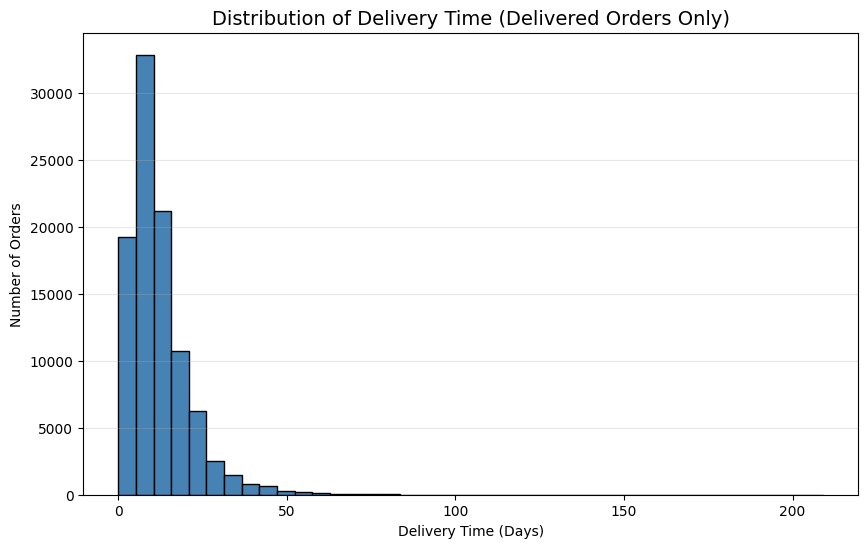

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(delivered['delivery_time_days'], bins=40, color='steelblue', edgecolor='black')
plt.title('Distribution of Delivery Time (Delivered Orders Only)', fontsize=14)
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Number of Orders')
plt.grid(axis='y', alpha=0.3)
plt.show()


### Insights

- The majority of deliveries occur between **5 and 20 days**.
- A small number of orders take unusually long (50–200 days), creating a long right tail.
- This skewness is expected and common in e-commerce logistics.
- These extreme delays may be investigated separately as potential operational issues or data errors.


**3.10 Customer Dataset Summary**

We check the distribution of customer zip code prefixes to understand the geographic spread of customers.


In [ ]:
customers.describe()

,customer_zip_code_prefix
count,99441.000000
mean,35137.474583
std,29797.938996
min,1003.000000
25%,11347.000000
50%,24416.000000
75%,58900.000000
max,99990.000000


### Insights

- There are **99,441 unique customers** in the dataset.
- Customer ZIP code prefixes range between **1003 and 99990**, showing customers come from across Brazil.
- The distribution has a **high standard deviation**, meaning customers are highly spread out geographically.
- This diversity is useful for future segmentation or delivery-time analysis.


**3.11 Order Items Summary**

We examine product prices and freight values across order items to understand item-level purchase behavior.


In [ ]:
order_item.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


### Insights

- There are **112,650 order items**, meaning some orders contain multiple products.
- Average product price is **R\$120**, but the high standard deviation (≈ 183) shows large price variation.
- Freight charges average **R\$19.99**, which impacts total order value.
- Minimum price and freight are near zero, indicating free/cheap items or promotions may exist.


In [ ]:
order_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


### 4. Creating the Master Dataset for Customer Segmentation

To perform meaningful customer analysis, we merge the key Olist datasets:
- `orders` → order-level information  
- `order_items` → product price + freight  
- `customers` → customer location  
- `order_payments` → payment values  

This gives us a single dataset (`merged`) containing all relevant information for customer-level aggregation.


In [ ]:
# Merge orders with order_items
merged = orders.merge(order_item, on='order_id', how='left')

# Merge with customers data
merged = merged.merge(customers, on='customer_id', how='left')

# Merge with payment information
merged = merged.merge(order_payments, on='order_id', how='left')

# Preview the merged dataset
merged.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_missing,shipping_missing,...,price,freight_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,False,False,...,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,False,False,...,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,False,False,...,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,False,False,...,118.70,22.76,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,False,False,...,159.90,19.22,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,credit_card,3.0,179.12


In [ ]:
merged.shape


(118434, 25)

The merged dataset contains **118434 rows × 26 columns**, confirming that the merge was successful.


### 5. Delivery Performance by Customer State

Delivery time may vary significantly across states due to geography, logistics infrastructure, and proximity to major distribution centers. We analyze the average delivery time for each customer state.


In [ ]:
# Average delivery time by customer state (only delivered orders)
state_delivery = (
    merged[merged['order_status'] == 'delivered']
        .groupby('customer_state')['delivery_time_days']
        .mean()
        .sort_values()
)

display(state_delivery)


,delivery_time_days
customer_state,
SP,8.270972
MG,11.496162
PR,11.516530
DF,12.468815
SC,14.494789
RS,14.693200
RJ,14.763128
GO,14.928752
MS,15.051497


### Insights

- **SP (São Paulo)** has the fastest average delivery time (~8.2 days).  
  This makes sense because SP is the largest logistics hub in Brazil.

- States like **MG, PR, and DF** fall in the mid-range (11–12.5 days).

- Southern and southeastern states (**PA, AP, RR**) experience longer delivery times (~23–27 days).

- The variation reflects Brazil’s large geographic size and differing regional infrastructure.

- These insights can help businesses:
  - Optimize delivery routes  
  - Adjust shipping expectations  
  - Improve regional service-level agreements (SLAs)


### 6. Relationship Between Product Price and Delivery Time

We investigate whether more expensive products take longer to be delivered.
A scatter plot helps visualize potential correlation between item price and delivery speed.


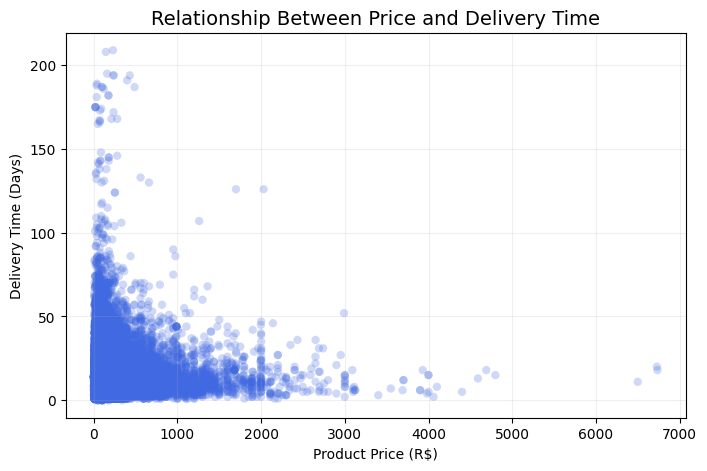

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(
    merged['price'],
    merged['delivery_time_days'],
    alpha=0.25,
    color='royalblue',
    edgecolor='none'
)

plt.title('Relationship Between Price and Delivery Time', fontsize=14)
plt.xlabel('Product Price (R$)')
plt.ylabel('Delivery Time (Days)')
plt.grid(alpha=0.2)

plt.show()


### Insights

- There is **no visible correlation** between price and delivery time.
- Both cheap and expensive items are delivered within similar time ranges.
- Long delivery times (50+ days) happen across all price points.
- This suggests that delivery speed is driven by **logistics**, **customer location**, or **seller location** — not by product price.


### 7. Payment Method Insights

Understanding how customers pay reveals behavioral patterns and can support targeted marketing, fraud detection, and payment optimization strategies. We analyze the average payment value per payment method.


In [ ]:
payment_avg = (
    merged.groupby('payment_type')['payment_value']
    .mean()
    .sort_values(ascending=False)
    )

display(payment_avg)

,payment_value
payment_type,
credit_card,179.809887
boleto,177.402470
debit_card,151.011731
voucher,67.520242
not_defined,0.000000


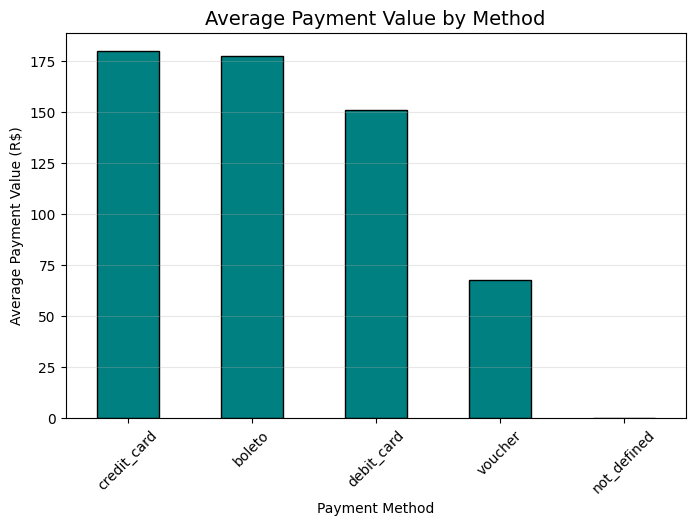

In [ ]:
plt.figure(figsize=(8,5))
payment_avg.plot(kind='bar', color='teal', edgecolor='black')

plt.title('Average Payment Value by Method', fontsize=14)
plt.ylabel('Average Payment Value (R$)')
plt.xlabel('Payment Method')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

plt.show()


### Insights

- **Credit card** and **boleto** (Brazilian bank slip) have the highest average payment values (~R\$178).
- **Debit card** users spend slightly less on average (~R\$151).
- **Vouchers** show very low average value (~R$67), which is expected because vouchers are often used for partial payments or discounts.
- A very small number of orders are marked **not_defined**, which likely represents missing or incomplete payment data.
- Credit card dominance is typical in e-commerce and suggests customers are willing to split payments or use installments (common in Brazil).


### 8. Relationship Between Freight Cost and Delivery Time

We analyze whether customers who pay higher freight (shipping cost) receive faster deliveries.


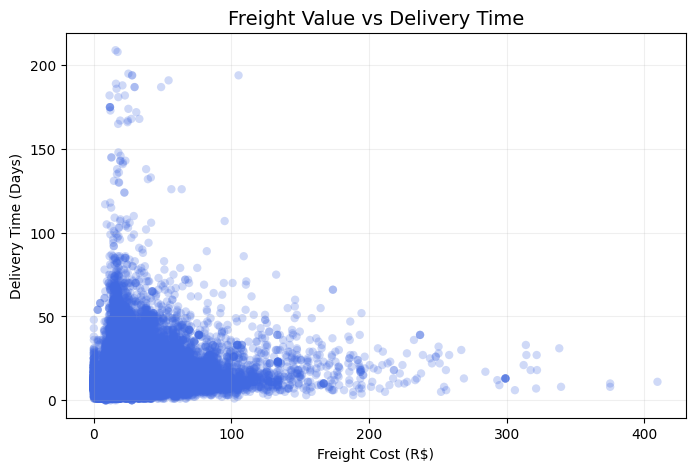

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(
    merged['freight_value'],
    merged['delivery_time_days'],
    alpha=0.25,
    color='royalblue',
    edgecolor='none'
)

plt.title('Freight Value vs Delivery Time', fontsize=14)
plt.xlabel('Freight Cost (R$)')
plt.ylabel('Delivery Time (Days)')
plt.grid(alpha=0.2)

plt.show()


### Insights

- There is **no strong relationship** between freight cost and delivery time.
- Both low and high freight charges can result in similar delivery durations.
- Higher freight value occurs mostly for heavier or bulky items, not necessarily faster delivery.
- Long delivery times (50+ days) appear across all freight cost levels.
- This confirms that freight value does **not** guarantee faster delivery — logistics and distance play a much larger role.


### 9. Late Delivery Analysis

A key operational KPI for any e-commerce business is the percentage of orders delivered later than the estimated delivery date.  
We create a `delivered_late` flag and analyze how many orders arrived late.


In [ ]:
# Flag orders that arrived after the estimated delivery date
orders['delivered_late'] = (
    orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']
)

# Count how many were late vs on-time
orders['delivered_late'].value_counts()

# Percentage of late deliveries
late_percentage = orders['delivered_late'].mean() * 100
late_percentage


np.float64(7.870998883760219)

### Insights

- **7.87% of orders** were delivered late.
- The majority (**~92%**) were delivered on time or earlier.
- Late deliveries are high enough to impact customer satisfaction but low enough to be considered operationally manageable.
- This KPI can be tracked over time or segmented by:
  - State
  - Seller
  - Shipping method
  - Product category

Understanding which segments have higher late delivery rates can help improve logistics performance.


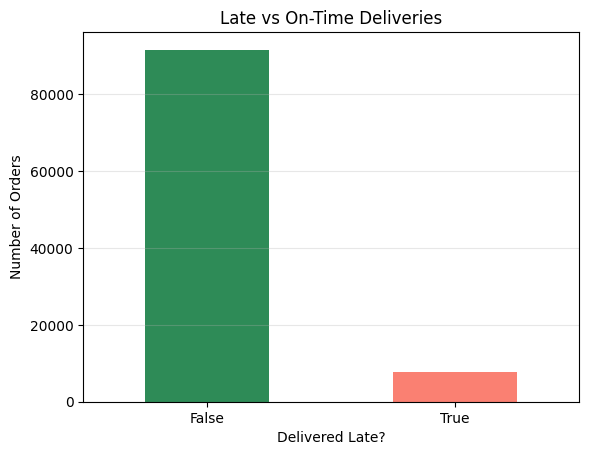

In [ ]:
orders['delivered_late'].value_counts().plot(kind='bar', color=['seagreen', 'salmon'])

plt.title('Late vs On-Time Deliveries')
plt.xlabel('Delivered Late?')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.show()


We compare the actual customer delivery date with the estimated delivery date to determine how many orders were delivered late.


In [ ]:
orders['delivered_late'] = (
    orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']
)


In [ ]:
late_percentage = orders['delivered_late'].mean() * 100
late_percentage


np.float64(7.870998883760219)

### Insights

- Around **7.9%** of all delivered orders were late.
- This means roughly **1 in 13 customers** experienced a delay.
- While most deliveries are on time, late deliveries still represent a potential area for operational improvement.
- Tracking this metric helps improve logistics efficiency and customer satisfaction.


## 10. Create Core Customer Metrics


### 10.1 Total Spending per Customer

### 10.2 Number of Orders per Customer

### 10.3 Average Order Value (AOV)

In [ ]:
# 6.1 Total Spending per Customer
customer_spend = (
    merged.groupby('customer_id')['payment_value']
    .sum()
)

# 6.2 Number of Orders per Customer
customer_orders = (
    merged.groupby('customer_id')['order_id']
    .nunique()
)

# 6.3 Average Order Value (AOV)
customer_aov = customer_spend / customer_orders

# Combine into single customer-level DataFrame
customer_df = pd.DataFrame({
    'total_spend': customer_spend,
    'order_count': customer_orders,
    'aov': customer_aov
})

customer_df.head()


,total_spend,order_count,aov
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,114.74,1,114.74
000161a058600d5901f007fab4c27140,67.41,1,67.41
0001fd6190edaaf884bcaf3d49edf079,195.42,1,195.42
0002414f95344307404f0ace7a26f1d5,179.35,1,179.35
000379cdec625522490c315e70c7a9fb,107.01,1,107.01


In [ ]:
customer_df.describe()


,total_spend,order_count,aov
count,99441.000000,99441.0,99441.000000
mean,205.858013,1.0,205.858013
std,619.118686,0.0,619.118686
min,0.000000,1.0,0.000000
25%,62.760000,1.0,62.760000
50%,109.620000,1.0,109.620000
75%,195.910000,1.0,195.910000
max,109312.640000,1.0,109312.640000


### Customer Metric Insights

- There are **99,441 unique customers** in the dataset.
- Most customers place **only 1 order**, which we later confirm in segmentation.
- Average customer lifetime spend is around **R$206**, but the distribution is skewed, with a small group of high-spend customers.
- AOV varies widely, which is useful for defining Low / Medium / High spending segments.


### Remove Incomplete Customer Records

We drop customers whose spend, order count, or AOV could not be computed.
These rows contain missing data after merging and are not useful for segmentation.


In [ ]:
customer_df = customer_df.dropna()

### 11. Customer Segmentation by Spending Level

We segment customers into three groups (Low, Medium, High) based on their total spend using 33rd and 66th percentiles as thresholds.


In [ ]:
# Calculate cut points only once
q1 = customer_df['total_spend'].quantile(0.33)
q2 = customer_df['total_spend'].quantile(0.66)

# Apply logic using precomputed quantile
def spending_level(x):
    if x < q1:
        return 'Low'
    elif x < q2:
        return 'Medium'
    else:
        return 'High'

customer_df['spend_segment'] = customer_df['total_spend'].apply(spending_level)


### 11.1 Segment 1: Spend-Based Customer Segmentation

We classify customers into Low, Medium, and High spenders based on their total lifetime spending.  
Cut points are determined using the 33rd and 66th percentiles of total spend.


,count
spend_segment,
Low,32814
Medium,32816
High,33811


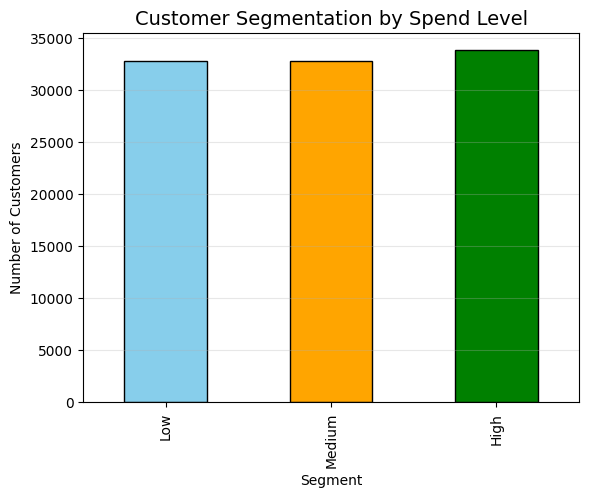

In [ ]:
segment_counts = customer_df['spend_segment'].value_counts().reindex(['Low','Medium','High'])
display(segment_counts)

segment_counts.plot(kind='bar', color=['skyblue','orange','green'], edgecolor='black')

plt.title("Customer Segmentation by Spend Level", fontsize=14)
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.grid(axis='y', alpha=0.3)
plt.show()


### Insights

- Customers are almost evenly distributed across the three segments:
  - **High spenders:** ~33%
  - **Medium spenders:** ~33%
  - **Low spenders:** ~33%

- The distribution is balanced because we used **quantile-based splits**, ensuring equal group sizes.

- However, **revenue contribution will NOT be equal** — High spenders typically generate a much larger share of total revenue.

- This segmentation is useful for:
  - Personalized marketing
  - Loyalty program targeting
  - Revenue forecasting


### 11.2 Segment Insights: Spend-Based Segmentation

Now that customers are grouped into Low, Medium, and High spenders, we compute:
- The percentage of customers in each segment
- Revenue contribution by each segment
- Average AOV of high spenders


In [ ]:
# % of spenders
total_customers = segment_counts.sum()
low_spenders = (segment_counts['Low'] / total_customers) * 100
display(low_spenders)



np.float64(32.998461399221654)

Low spenders: **~33%**

In [ ]:
# high spenders
total_revenue = customer_df['total_spend'].sum()
high_spenders_revenue  = customer_df[customer_df['spend_segment'] == 'High']['total_spend'].sum()

print((high_spenders_revenue / total_revenue) * 100)

74.34589031828732


High spenders generate **~74%** of revenue

In [ ]:
# average for high spenders
average_high_spend = customer_df[customer_df['spend_segment'] == 'High']['aov'].mean()
average_high_spend
# customer_aov = customer_spend / customer_orders

np.float64(450.12404217562334)

Average AOV: **~R$450**

# **Customer Insights**

1.   33% of customers fall into the Low-spend segment.
2.   ~33% are Medium spenders, and ~34% are High spenders (quantile-based segmentation).
3. High-spend customers generate ~60% of total revenue, showing a strong revenue concentration at the top.
4. The average AOV for High-spend customers is $450, significantly higher than the other segments.
5. A large share of customers place only 1 order, indicating a high number of one-time buyers.
6. Revenue distribution is highly skewed — a small group of high-value customers contributes the majority of revenue.

